# How to convert a cross-section to a SEGY file?

This notebook is part of a blog post on [Geophysics Labs](http://geophysicslabs.com/2017/02/12/how-to-add-cross-sections-to-opendtect/)

The example shown here makes use of the Kevitsa dataset that was made freely available by the [Frank Arnott Award](https://www.frankarnottaward.com/Home.aspx).
<hr />
This notebook makes use of the [obspy](https://github.com/obspy/obspy/wiki) library to create the final SEGY file. If you use Anaconda, installing obspy should be as easy as typing:
```
conda install obspy
```

Now let's start by loading what we need for this notebook to work.

In [1]:
import numpy as np
# for plotting results
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
# for resizing and resampling
from scipy.ndimage import interpolation
# for the quantization
from sklearn.metrics import pairwise_distances_argmin
# for exporting to SEGY
from obspy.core import Trace, Stream, Stats
from obspy.io.segy.segy import SEGYBinaryFileHeader, SEGYTraceHeader
import datetime
# for displaying the plots in the notebook
%matplotlib inline

## Load image in a Numpy array

The first step is to read the image of the cross-section. This image has been extracted from a PDF file and cropped to the reference points: start and end, top and bottom.

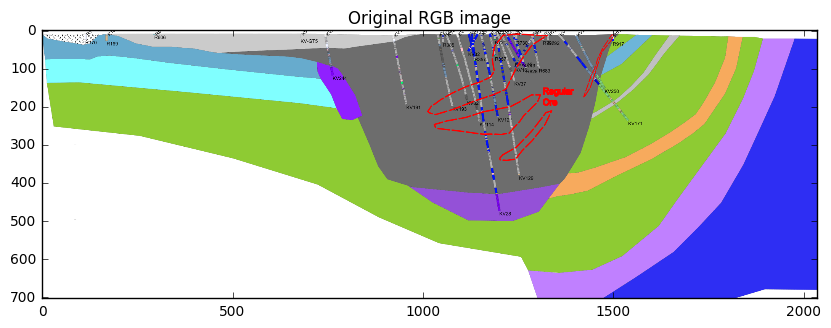

In [2]:
inFile = r'..\data\Kevitsa_Titan_Line_E5_crop.png'
imRGB = plt.imread(inFile)
# plot
fig,ax = plt.subplots(figsize=(10,6))
ax.imshow(imRGB,aspect='equal')
plt.title('Original RGB image')

## Resampling and resizing

Resizing is not always necessary but it can improve the final result in OpendTect. The image is stretched vertically by interpolation, therefore creating new pixels. This will mimic the fact that the resolution of seismic data is generally better vertically than horizontally.

There are lots of different methods and libraries for resampling images. I am using a convenient function that can be found in Scipy. Nearest-neighbour interpolation is essential here to preserve the hard edges of the image.

In [3]:
imRGB.shape

(704, 2035, 3)

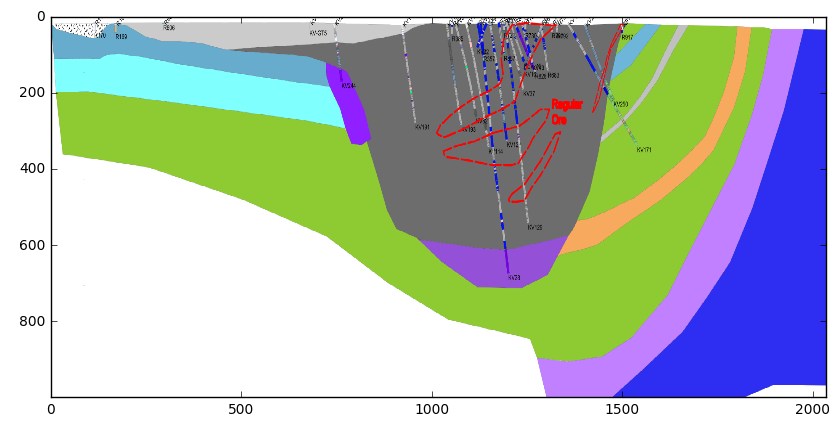

In [4]:
# I want to increase the number of rows from 704 to 1000, so:
stretch_factor = 1000./704

# Nearest-neighbour interpolation
imRGB_resized = interpolation.zoom(imRGB,zoom=(stretch_factor,1,1),order=0)
fig,ax = plt.subplots(figsize=(10,6))
ax.imshow(imRGB_resized,aspect='equal')

## Color Quantization
As for the previous example with the map, we first need to load the palette, which is a list of colours that we consider as fixed.

In [5]:
inFile = r'..\data\Windows_256_color_palette_RGB.csv'
win256 = np.loadtxt(inFile,delimiter=',')

This is a three-column array of RGB colours.

Next, we have to reshape our input image to make sure it fits the same format.

In [6]:
nrows,ncols,d = imRGB_resized.shape
flat_array = np.reshape(imRGB_resized, (nrows*ncols, 3))
flat_array[:5]

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

Now we can compute the colours in the palette that are the closest to the colour of each pixel in our RGB image. This can be done easily using the `pairwise_distances_argmin` function available in the [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html#sklearn-metrics-pairwise-distances-argmin) library. 

In [7]:
# run function, making sure the palette data is normalised to the 0-1 interval
indices = pairwise_distances_argmin(flat_array,win256/255)
# reshape the indices to the shape of the initial image
indexedImage  = indices.reshape((nrows,ncols))

To properly display the result with matplotlib, we have to create the appropriate colormap with the colours of the Windows palette. This is done with a function of the `colors` sub-module in [matplotlib](http://matplotlib.org/api/colors_api.html).

In [8]:
new_cm = mcolors.LinearSegmentedColormap.from_list('win256', win256/255)
plt.register_cmap(cmap=new_cm)  # optional but useful to be able to call the colormap by its name.

Now show the indexed-color image:

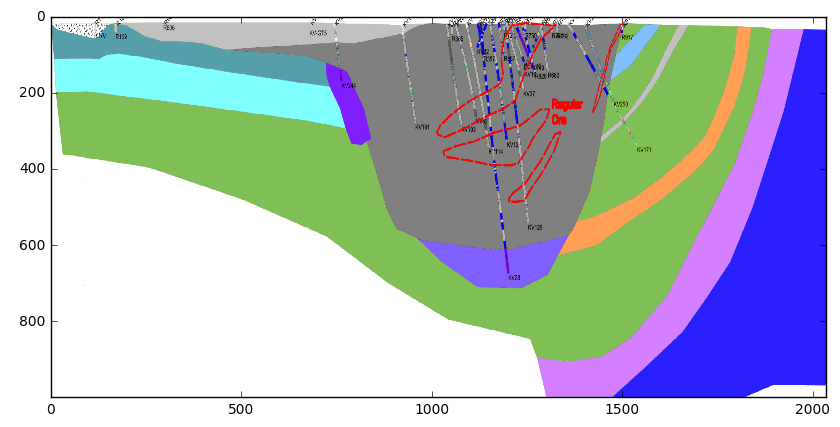

In [9]:
fig,ax = plt.subplots(figsize=(10,6))
ax.imshow(indexedImage,cmap='win256',norm=mcolors.NoNorm(),aspect='equal')

In [10]:
# save array to file
outFile = r'..\data\Kevitsa_Titan_Line_E5_oneband.npy'
np.save(outFile,indexedImage)

## Write output to SEGY with obspy

In order to write the indexed image into a SEGY file, we need the (X,Y) coordinates of each trace. The coordinates of the start and end points are provided in a text file that came with the sections:

    Line:		Start (X)	(Y):		Finish (X)	(Y):
        E5  	 3496937	7509361	   3500188	7514290
        
The number of columns in the image `nrows` will become the number of traces in the "*pseudo seismic line*". The profile of the cross-section is considered to be a straight line on the map, and we can therefore calculate the trace coordinates by interpolating between the two extreme points.

In [11]:
xStart = 3496937
yStart = 7509361
xEnd = 3500188
yEnd = 7514290
# create linearly interpolated sequence of points between the two ends of the line
traces = np.arange(ncols)
X = np.interp(traces,[0,ncols-1],[xStart,xEnd])
Y = np.interp(traces,[0,ncols-1],[yStart,yEnd])

In the other dimension, i.e. the vertical depth axis, the rows of the image will become the trace samples. To create the output SEGY file, we need to calculate the depth interval between each sample. Knowing that the top of the section is around -250 m and the bottom at +1500 m, the depth interval is (in km):

In [12]:
dt = 1750 / nrows / 1000
dt

0.00175

Let's convert the input array to 32-bit float numbers. It seems like a requirement for the SEGY format.

In [13]:
# convert data format
data = np.asarray(indexedImage,dtype=np.float32)
data.dtype

dtype('float32')

In [14]:
# create coordinate vectors with applied scaling factor
scaler = 100
Xint = np.round(X*scaler).astype(np.int)
Yint = np.round(Y*scaler).astype(np.int)
Xint.dtype

dtype('int32')

In [15]:
# Make a new Stream object
out = Stream() 
# For each column in the image, create a new trace
for i,t in enumerate(data.T):       
    trace = Trace(t, header={'delta': dt }) 
    out.append(trace)

In [16]:
# create trace headers with trace coordinates
for i,trace in enumerate(out):
    trace.stats.segy = {}
    trace.stats.segy.trace_header = SEGYTraceHeader()
    
    trace.stats.segy.trace_header.trace_sequence_number_within_line = i+1
    trace.stats.segy.trace_header.sample_interval_in_ms_for_this_trace = dt
    trace.stats.segy.trace_header.number_of_samples_in_this_trace = len(trace)
    trace.stats.segy.trace_header.scalar_to_be_applied_to_all_coordinates = -1*scaler
    trace.stats.segy.trace_header.delay_recording_time = 0
    trace.stats.segy.trace_header.source_coordinate_x= Xint[i]
    trace.stats.segy.trace_header.source_coordinate_y= Yint[i]
    trace.stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace= Xint[i]
    trace.stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace=Yint[i]

In [17]:
# create text header
text_header = '{0:<80}'.format("File created on "+datetime.date.today().isoformat())
text_header += '{0:<80}'.format("Coordinates of the line:")
text_header += '{0:<80}'.format("LeftX   : "+ str(int(X[0])))
text_header += '{0:<80}'.format("LeftY   : "+ str(int(Y[0])))
text_header += '{0:<80}'.format("RightX  : "+ str(int(X[-1])))
text_header += '{0:<80}'.format("RightY  : "+ str(int(Y[-1])))

# Add text and binary headers to stream
out.stats = Stats(dict(textual_file_header=text_header.encode('utf-8')))
out.stats.binary_file_header = SEGYBinaryFileHeader()
out.stats.binary_file_header.number_of_data_traces_per_ensemble = 1
out.stats.binary_file_header.number_of_samples_per_data_trace = len(trace)

In [18]:
# create SEGY file
outFile = r'..\data\Kevitsa_Titan_Line_E5.sgy'
print("\nCreating " + outFile)
out.write(outFile, format='SEGY', data_encoding=5) 
print("Done!")


Creating ..\data\Kevitsa_Titan_Line_E5.sgy
Done!
